In [1]:
!pip install bm3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.0/862.0 kB 8.9 MB/s eta 0:00:00


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

from skimage import io, img_as_float
from skimage.util import random_noise
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio as psnr

from bm3d import bm3d

import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D,
                                     UpSampling2D, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)


In [4]:
CBSD68_PATH = "/content/drive/MyDrive/Datasets/CBSD68/original_png"
KODAK_PATH  = "/content/drive/MyDrive/Datasets/kodak_24/kodak24"
UNET_MODEL_PATH = "/content/drive/MyDrive/Datasets/unet_denoising_hd.keras"



In [5]:
def load_images(folder, max_images=None):
    images = []
    valid_ext = (".png", ".jpg", ".jpeg", ".bmp", ".tif")

    files = sorted([
        f for f in os.listdir(folder)
        if f.lower().endswith(valid_ext)
    ])

    if max_images is not None:
        files = files[:max_images]

    for fname in tqdm(files, desc="Loading images"):
        path = os.path.join(folder, fname)
        img = Image.open(path).convert("L")  # grayscale
        img = np.asarray(img, dtype=np.float32) / 255.0
        images.append(img)

    print(f"Loaded {len(images)} images from {folder}")
    return images


def add_gaussian_noise(img, sigma=0.1):
    noisy = img + sigma * np.random.randn(*img.shape)
    return np.clip(noisy, 0.0, 1.0)

def add_salt_pepper_noise(img, amount=0.05):
    noisy = random_noise(img, mode="s&p", amount=amount)
    return noisy.astype(np.float32)


def extract_patches(images, patch_size=64, stride=32, max_patches=20000):
    X_clean = []
    X_noisy = []

    for img in images:
        h, w = img.shape
        for i in range(0, h - patch_size + 1, stride):
            for j in range(0, w - patch_size + 1, stride):
                clean = img[i:i+patch_size, j:j+patch_size]
                noise = np.random.normal(0, 25/255.0, clean.shape)
                noisy = np.clip(clean + noise, 0, 1)

                X_clean.append(clean)
                X_noisy.append(noisy)

                if len(X_clean) >= max_patches:
                    return (
                        np.array(X_noisy)[..., None],
                        np.array(X_clean)[..., None]
                    )

    return (
        np.array(X_noisy)[..., None],
        np.array(X_clean)[..., None]
    )



In [6]:
def apply_nlm(noisy_img):
    sigma_est = np.mean(estimate_sigma(noisy_img))
    denoised = denoise_nl_means(
        noisy_img,
        h=1.15 * sigma_est,
        fast_mode=True,
        patch_size=5,
        patch_distance=6,
        channel_axis=None
    )
    return np.clip(denoised, 0.0, 1.0)

def apply_bm3d(noisy_img, sigma=0.1):
    return np.clip(bm3d(noisy_img, sigma_psd=sigma), 0.0, 1.0)




In [7]:
def build_unet(input_shape=(128, 128, 1)):
    inputs = layers.Input(shape=input_shape)

    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(c3)

    u2 = layers.UpSampling2D()(c3)
    u2 = layers.concatenate([u2, c2])
    c4 = layers.Conv2D(128, 3, activation="relu", padding="same")(u2)
    c4 = layers.Conv2D(128, 3, activation="relu", padding="same")(c4)

    u1 = layers.UpSampling2D()(c4)
    u1 = layers.concatenate([u1, c1])
    c5 = layers.Conv2D(64, 3, activation="relu", padding="same")(u1)
    c5 = layers.Conv2D(64, 3, activation="relu", padding="same")(c5)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c5)

    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse")
    return model


In [8]:
def apply_unet(model, noisy_img):
    """
    noisy_img: 2D grayscale image in [0,1]
    model: U-Net trained on RGB images
    """

    # grayscale → fake RGB
    rgb = np.stack([noisy_img]*3, axis=-1)        # (H, W, 3)
    rgb = rgb[np.newaxis, ...]                    # (1, H, W, 3)

    # inference
    out = model.predict(rgb, verbose=0)[0]        # (H, W, 3)

    # RGB → grayscale
    gray = np.mean(out, axis=-1)

    return np.clip(gray, 0.0, 1.0)


In [9]:
model = tf.keras.models.load_model(UNET_MODEL_PATH)
print("U-Net model loaded successfully")

U-Net model loaded successfully


In [10]:
print("Loading CBSD68 dataset...")
train_images = load_images(CBSD68_PATH, max_images=68)
X_noisy, X_clean = extract_patches(train_images)

print("Extracting patches...")
X_noisy, X_clean = extract_patches(
    train_images,
    patch_size=64,
    stride=32,
    max_patches=20000
)

print(X_noisy.shape, X_clean.shape)


Loading CBSD68 dataset...


Loading images: 100%|██████████| 68/68 [00:21<00:00,  3.22it/s]


Loaded 68 images from /content/drive/MyDrive/Datasets/CBSD68/original_png
Extracting patches...
(8568, 64, 64, 1) (8568, 64, 64, 1)


Loading images: 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]


Loaded 5 images from /content/drive/MyDrive/Datasets/kodak_24/kodak24

Kodak Image 1 – PSNR (Gaussian)
Noisy : 20.055542867561265
NLM   : 24.277310530351556
BM3D  : 27.13439760459243
U-Net : 25.475604062894863


/tmp/ipython-input-2994471454.py:12: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print("Noisy :", psnr(img, noisy_g))
/tmp/ipython-input-2994471454.py:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print("NLM   :", psnr(img, nlm_g))
/tmp/ipython-input-2994471454.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print("BM3D  :", psnr(img, bm3d_g))


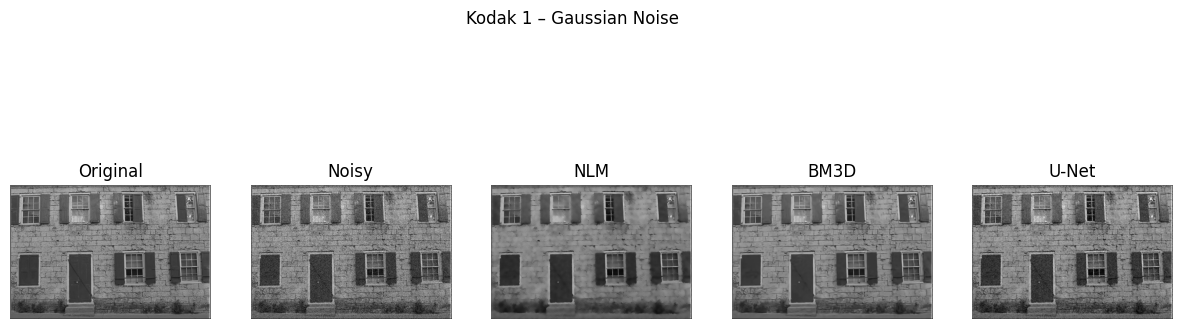

In [ ]:
test_images = load_images(KODAK_PATH, max_images=5)

for idx, img in enumerate(test_images):

    noisy_g = add_gaussian_noise(img)

    nlm_g  = apply_nlm(noisy_g)
    bm3d_g = apply_bm3d(noisy_g)
    unet_g = apply_unet(model, noisy_g)

    print(f"\nKodak Image {idx+1} – PSNR (Gaussian)")
    print("Noisy :", psnr(img, noisy_g))
    print("NLM   :", psnr(img, nlm_g))
    print("BM3D  :", psnr(img, bm3d_g))
    print("U-Net :", psnr(img, unet_g))

    titles = ["Original", "Noisy", "NLM", "BM3D", "U-Net"]
    images = [img, noisy_g, nlm_g, bm3d_g, unet_g]

    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(titles[i])
        plt.axis("off")

    plt.suptitle(f"Kodak {idx+1} – Gaussian Noise")
    plt.show()

Loading images: 100%|██████████| 5/5 [00:00<00:00, 68.04it/s]


Loaded 5 images from /content/drive/MyDrive/Datasets/kodak_24/kodak24


/tmp/ipython-input-2450425324.py:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_sp["BM3D"].append(psnr(img, bm3d_sp))
/tmp/ipython-input-2450425324.py:29: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print("BM3D  :", psnr(img, bm3d_sp))



Kodak Image 1 – PSNR (Salt & Pepper)
Noisy : 18.523468064419536
NLM   : 18.642358903222277
BM3D  : 24.28954290050704
U-Net : 23.091655546673554


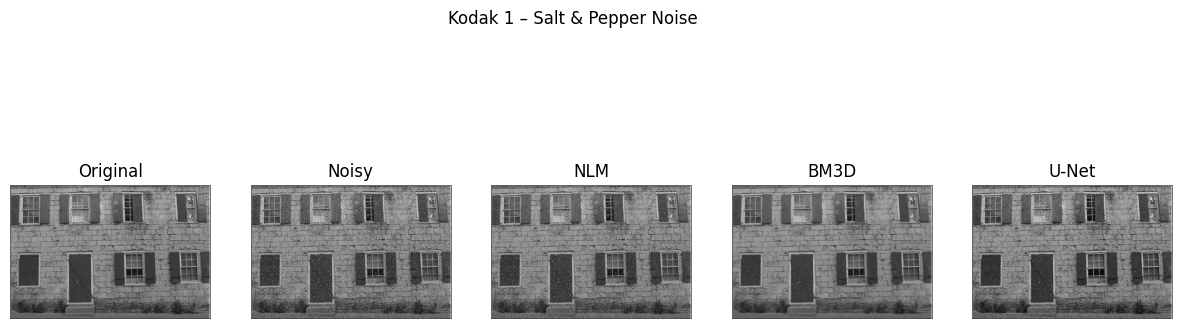


Kodak Image 2 – PSNR (Salt & Pepper)
Noisy : 18.390913276909505
NLM   : 18.47525548955901
BM3D  : 23.041926402726567
U-Net : 23.830203155858356


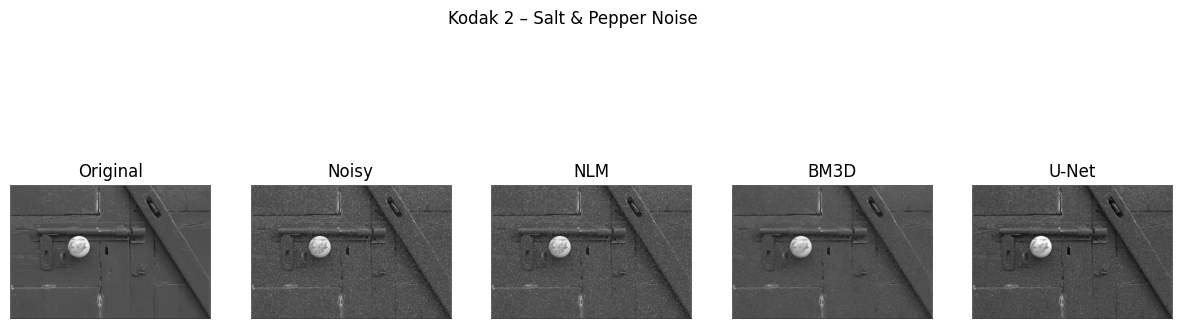


Kodak Image 3 – PSNR (Salt & Pepper)
Noisy : 18.475064857442128
NLM   : 18.53286382126499
BM3D  : 24.48325469755327
U-Net : 24.358253440832087


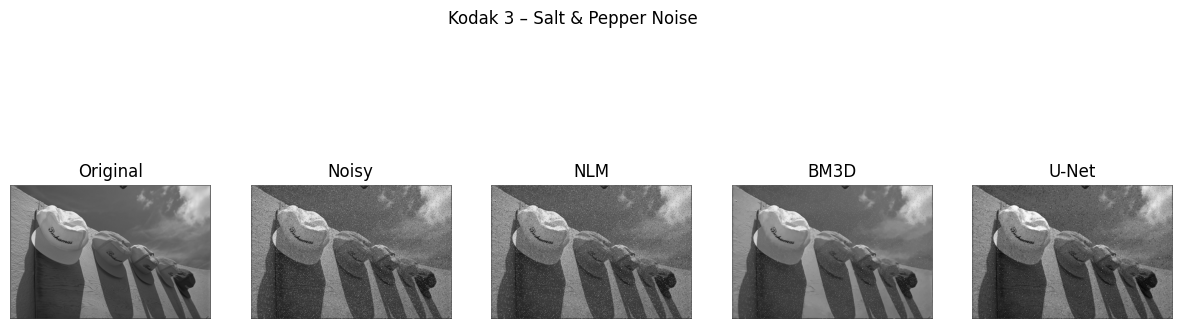


Kodak Image 4 – PSNR (Salt & Pepper)
Noisy : 18.49132277627087
NLM   : 18.526420425763117
BM3D  : 24.539949548987153
U-Net : 24.272987964560798


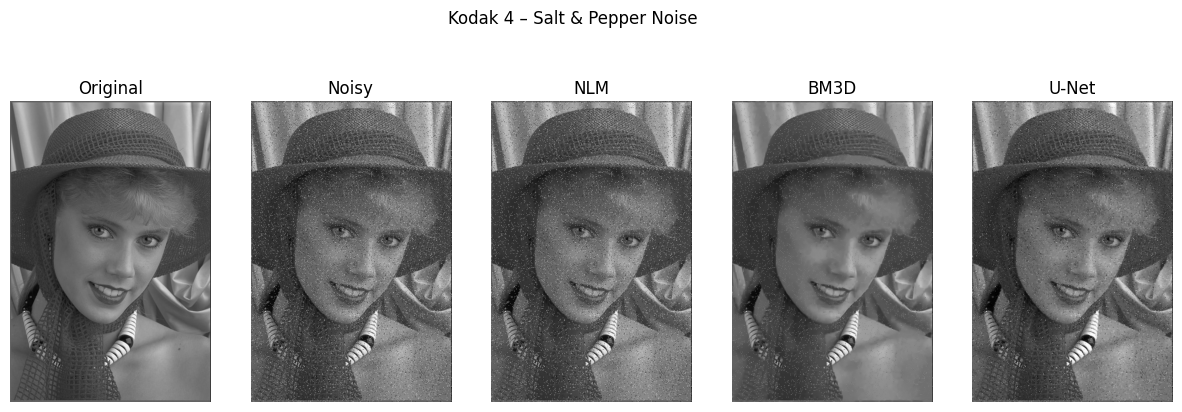


Kodak Image 5 – PSNR (Salt & Pepper)
Noisy : 17.956172404142453
NLM   : 18.048754638908548
BM3D  : 22.650038060618645
U-Net : 22.612094034670758


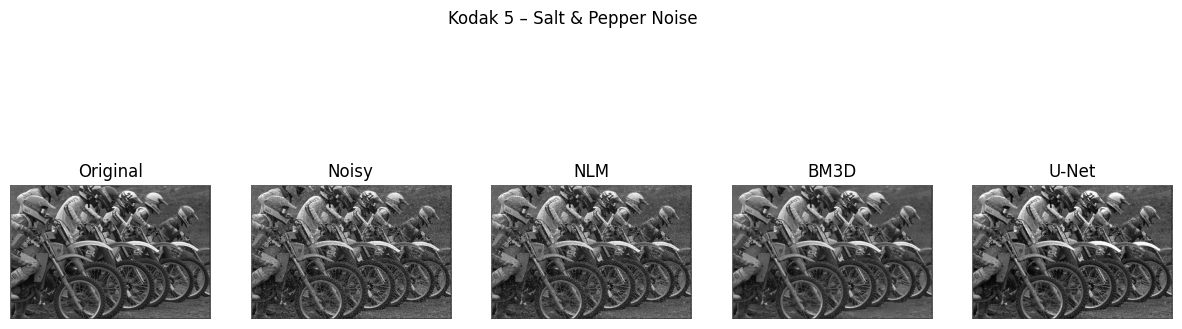

In [ ]:
psnr_sp = {
    "Noisy": [],
    "NLM": [],
    "BM3D": [],
    "U-Net": []
}

test_images = load_images(KODAK_PATH, max_images=5)

for idx, img in enumerate(test_images):

    noisy_sp = add_salt_pepper_noise(img, amount=0.05)

    nlm_sp  = apply_nlm(noisy_sp)
    bm3d_sp = apply_bm3d(noisy_sp, sigma=0.1)
    unet_sp = apply_unet(model, noisy_sp)

    psnr_sp["Noisy"].append(psnr(img, noisy_sp))
    psnr_sp["NLM"].append(psnr(img, nlm_sp))
    psnr_sp["BM3D"].append(psnr(img, bm3d_sp))
    psnr_sp["U-Net"].append(psnr(img, unet_sp))

    print(f"\nKodak Image {idx+1} – PSNR (Salt & Pepper)")
    print("Noisy :", psnr(img, noisy_sp))
    print("NLM   :", psnr(img, nlm_sp))
    print("BM3D  :", psnr(img, bm3d_sp))
    print("U-Net :", psnr(img, unet_sp))

    titles = ["Original", "Noisy", "NLM", "BM3D", "U-Net"]
    images = [img, noisy_sp, nlm_sp, bm3d_sp, unet_sp]

    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(titles[i])
        plt.axis("off")

    plt.suptitle(f"Kodak {idx+1} – Salt & Pepper Noise")
    plt.show()


In [ ]:
print("\n===== MEAN PSNR (Salt & Pepper Noise) =====")
for k, v in psnr_sp.items():
    print(f"{k:6s}: {np.mean(v):.2f} dB")



===== MEAN PSNR (Salt & Pepper Noise) =====
Noisy : 18.37 dB
NLM   : 18.45 dB
BM3D  : 23.80 dB
U-Net : 23.63 dB


In [ ]:
# ============================================================
# FINAL EVALUATION – GAUSSIAN NOISE (24 images)
# ============================================================
psnr_g = {"Noisy": [], "NLM": [], "BM3D": [], "U-Net": []}

test_images = load_images(KODAK_PATH)  # ΟΛΟ το dataset

for img in test_images:
    noisy = add_gaussian_noise(img)

    psnr_g["Noisy"].append(psnr(img, noisy, data_range=1.0))
    psnr_g["NLM"].append(psnr(img, apply_nlm(noisy), data_range=1.0))
    psnr_g["BM3D"].append(psnr(img, apply_bm3d(noisy), data_range=1.0))
    psnr_g["U-Net"].append(psnr(img, apply_unet(model, noisy), data_range=1.0))

print("\n===== FINAL MEAN PSNR – GAUSSIAN NOISE =====")
for k in psnr_g:
    print(f"{k:6s}: {np.mean(psnr_g[k]):.2f} dB")


Loading images: 100%|██████████| 24/24 [00:01<00:00, 18.27it/s]


Loaded 24 images from /content/drive/MyDrive/Datasets/kodak_24/kodak24

===== FINAL MEAN PSNR – GAUSSIAN NOISE =====
Noisy : 20.22 dB
NLM   : 27.62 dB
BM3D  : 29.94 dB
U-Net : 26.70 dB


In [ ]:
# ============================================================
# FINAL EVALUATION – SALT & PEPPER NOISE (24 images)
# ============================================================
psnr_sp = {"Noisy": [], "NLM": [], "BM3D": [], "U-Net": []}

test_images = load_images(KODAK_PATH)  # ΟΛΟ το dataset

for img in test_images:
    noisy = add_salt_pepper_noise(img, amount=0.05)

    psnr_sp["Noisy"].append(psnr(img, noisy))
    psnr_sp["NLM"].append(psnr(img, apply_nlm(noisy)))
    psnr_sp["BM3D"].append(psnr(img, apply_bm3d(noisy)))
    psnr_sp["U-Net"].append(psnr(img, apply_unet(model, noisy)))

print("\n===== FINAL MEAN PSNR – SALT & PEPPER NOISE =====")
for k in psnr_sp:
    print(f"{k:6s}: {np.mean(psnr_sp[k]):.2f} dB")


Loading images: 100%|██████████| 24/24 [00:00<00:00, 61.14it/s]


Loaded 24 images from /content/drive/MyDrive/Datasets/kodak_24/kodak24


/tmp/ipython-input-3690054195.py:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_sp["BM3D"].append(psnr(img, apply_bm3d(noisy)))



===== FINAL MEAN PSNR – SALT & PEPPER NOISE =====
Noisy : 18.25 dB
NLM   : 18.30 dB
BM3D  : 23.65 dB
U-Net : 23.83 dB
